# Load in Data

In [3]:
from formulas import *
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# from scikit-learn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras

### Update Data
To update the SPY.csv data uncomment all the lines of the cell below and rerun. If enough time has passed, you may want to look at changing the splits of the validation data, test data, and the train data.

In [4]:
import yfinance as yf

spy = yf.Ticker("SPY")

# get stock info
spy.info

# get historical market data as df
hist = spy.history(period="max")

# Save df as CSV
hist.to_csv('../SPY.CSV')

In [7]:
# Read data in to dataframes
spy = pd.read_csv('../SPY.csv')
# dia = pd.read_csv('etfs/DIA.csv')
# qqq = pd.read_csv('etfs/QQQ.csv')


# Change date column to datetime type
spy['Date'] = pd.to_datetime(spy['Date'], utc=True)
# dia['Date'] = pd.to_datetime(dia['Date'])
# qqq['Date'] = pd.to_datetime(qqq['Date'])

# # View amount of daily data
# print(f'There are {spy.shape[0]} rows in SPY and {dia.shape[0]} DIA rows')
# print('*'*100)
# print(f'''The date range of SPY is {spy.index.min()} to {spy.index.max()} 
#        \n DIA is {dia.index.values.min()} to {dia.index.max()}
#        \n QQQ is {qqq.index.min()} to {qqq.index.max()}''')

### SPY Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just shy of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

I will be choosing an arbitrary date to separate the training, validation, and test data.

In [12]:
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

IndexError: index 0 is out of bounds for axis 0 with size 0

5521 5522 6527 6528 6949


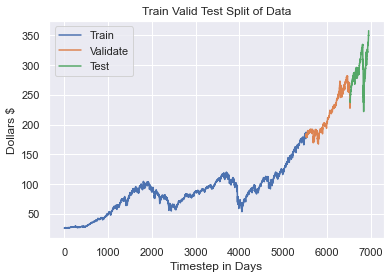

In [7]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [8]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting
A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.

Text(0.5, 1.0, 'Price History of SPY Jan-1993 to Sept-2020')

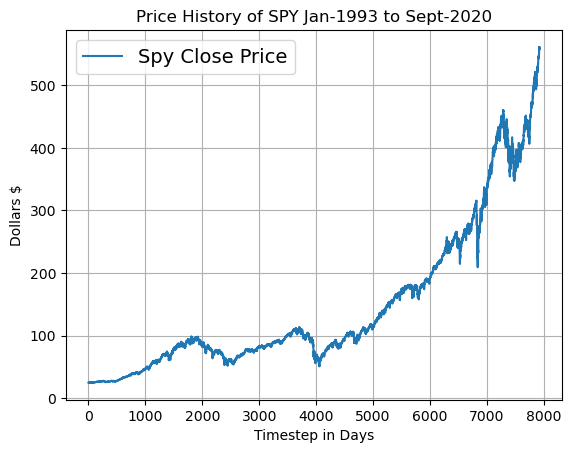

In [8]:
# Plot chart with all details untouched
plot_series(time=spy.index,series=spy['Close'], label = 'Spy Close Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Price History of SPY Jan-1993 to Sept-2020')

In [10]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Naive Forecast vs Actual')

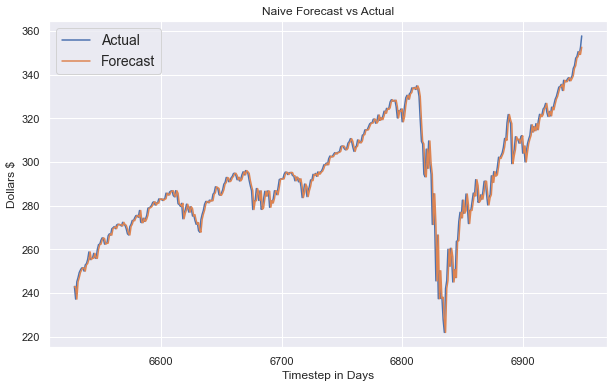

In [37]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Naive Forecast vs Actual')

### Calculate Error in Naive Model

In [12]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 2.722772511848341}

In [13]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[242.77 243.03 237.23]
[243.03 237.23 245.17]
****************************************************************************************************
[0.26 5.8  7.94]


# Monthly Moving Average Model (20 Day MA)
Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

In [9]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')

NameError: name 'test_split_index' is not defined

In [17]:
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 2.722772511848341, 'SMA 20': 16.962856635071123}

# Weekly Moving Average (5 day MA)
I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

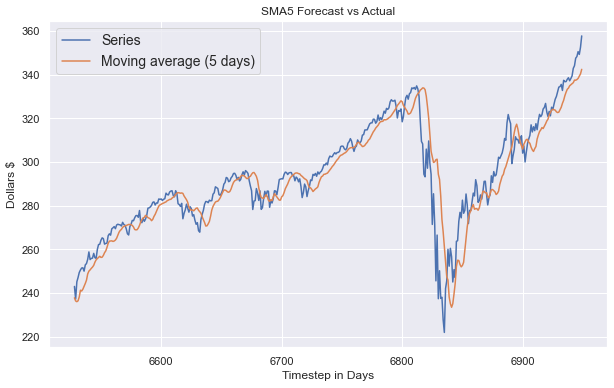

In [18]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [19]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

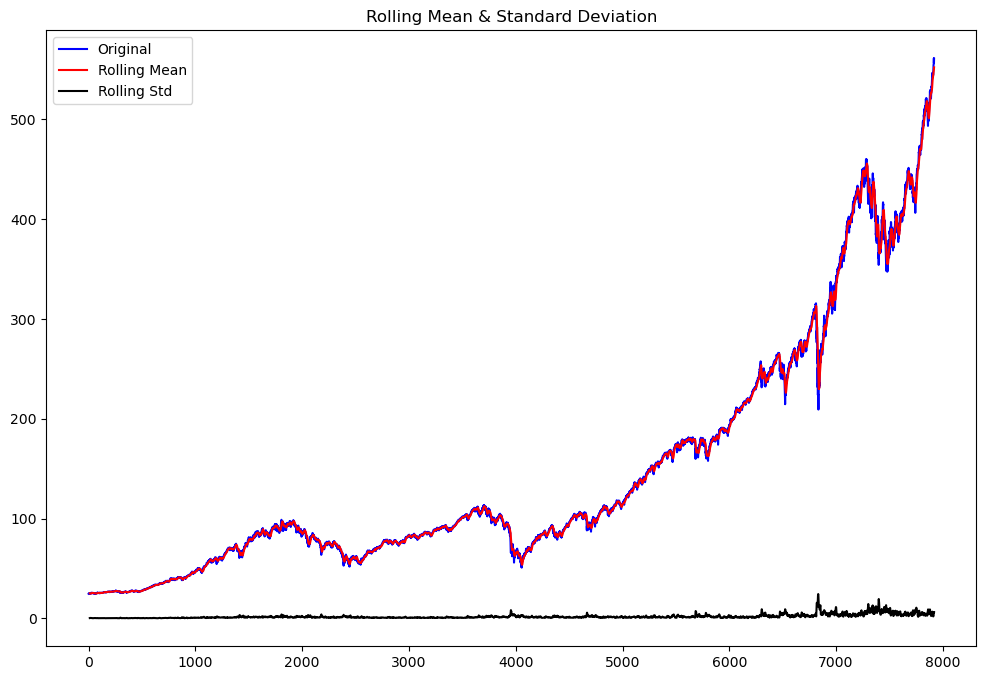

Results of Dickey-Fuller Test:
p-value = 1.0000. The series is likely non-stationary.
Test Statistic                    3.231638
p-value                           1.000000
#Lags Used                       15.000000
Number of Observations Used    7903.000000
Critical Value (1%)              -3.431178
Critical Value (5%)              -2.861906
Critical Value (10%)             -2.566965
dtype: float64


In [13]:
series = spy['Close']
test_stationarity(series)

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [14]:
# Get the difference of each Adj Close point
spy_close_diff_1 = series.diff()
spy_close_diff_1.dropna(inplace=True)

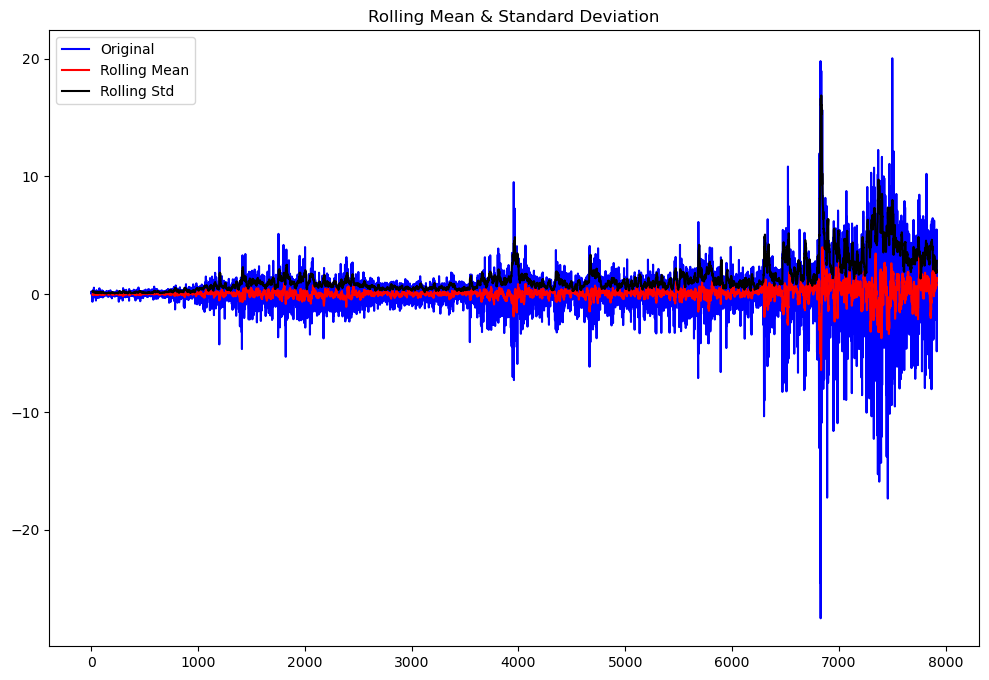

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -23.394280
p-value                           0.000000
#Lags Used                       14.000000
Number of Observations Used    7903.000000
Critical Value (1%)              -3.431178
Critical Value (5%)              -2.861906
Critical Value (10%)             -2.566965
dtype: float64


In [15]:
# Plot the spy Adj Close 1st order difference
test_stationarity(spy_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

### Step 3: Autocorrelation and Partial autocorrelation
Autocorrelation is the correlation between points at time t (Pₜ) and the point at(Pₜ₋₁). Partial autocorrelation is the point at time t (Pₜ) and the point (Pₜ₋ₖ) where k is any number of lags. Partial autocorrelation ignores all of the data in between both points.

In terms of a movie theater’s ticket sales, autocorrelation determines the relationship of today’s ticket sales and yesterday’s ticket sales. In comparison, partial autocorrelation defines the relationship of this Friday’s ticket sales and last Friday’s ticket sales.

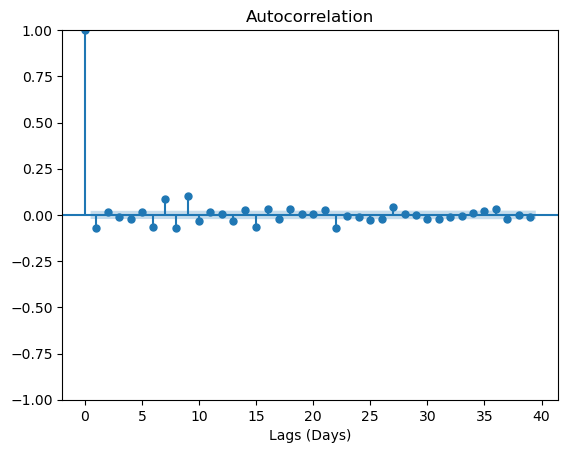

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(spy_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

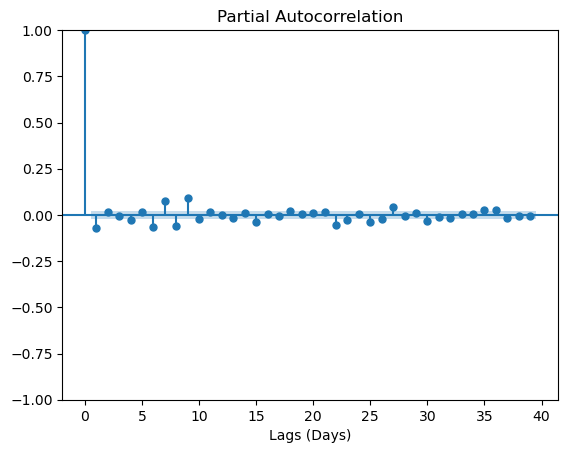

In [17]:
plot_pacf(spy_close_diff_1)
plt.xlabel('Lags (Days)')
plt.show()

- These plots look almost identical, but they’re not. Let’s start with the Autocorrelation plot. The important detail of these plots is the first lag. If the first lag is positive, we use an autoregressive (AR) model, and if the first lag is negative, we use a moving average (MA) plot. Since the first lag is negative, and the 2nd lag is positive, we will use the 1st lag as a moving average point.
<br/><br/>
- For the PACF plot, since there is a substantial dropoff at lag one, which is negatively correlated, we will use an AR factor of 1 as well. If you have trouble determining how what lags are the best to use, feel free to experiment, and watch the AIC. The lower the AIC, the better.
<br/><br/>
- The ARIMA model takes three main inputs into the “order” argument. Those arguments are ‘p’ for the AR term, ‘d’ for the differencing term, ‘q’ for the MA term. We have determined the best model for our data is of order (1,1,1). Once again, feel free to change these numbers and print out the summary of the models to see which variation has the lowest AIC. The training time is relatively quick.

### Testing different arima models

In [18]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
spy_arima = ARIMA(x_train, order=(1,1,1))
spy_arima_fit = spy_arima.fit(disp=0)
print(spy_arima_fit.summary())

NameError: name 'x_train' is not defined

NormaltestResult(statistic=863.6353376774764, pvalue=2.910510933059743e-188)
This distribution is not a normal distribution


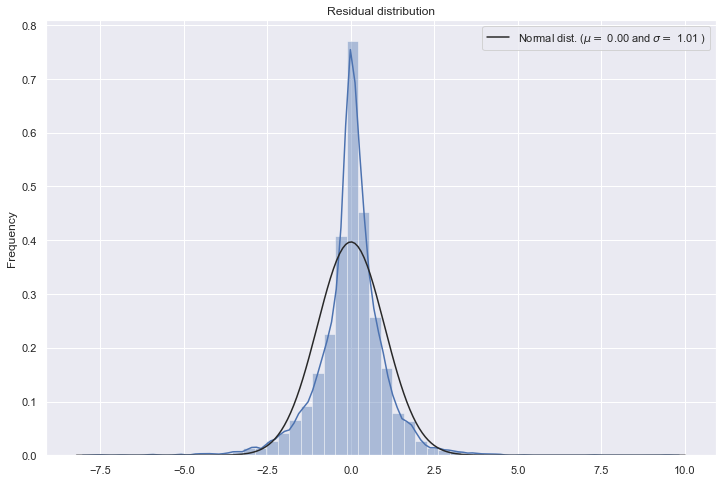

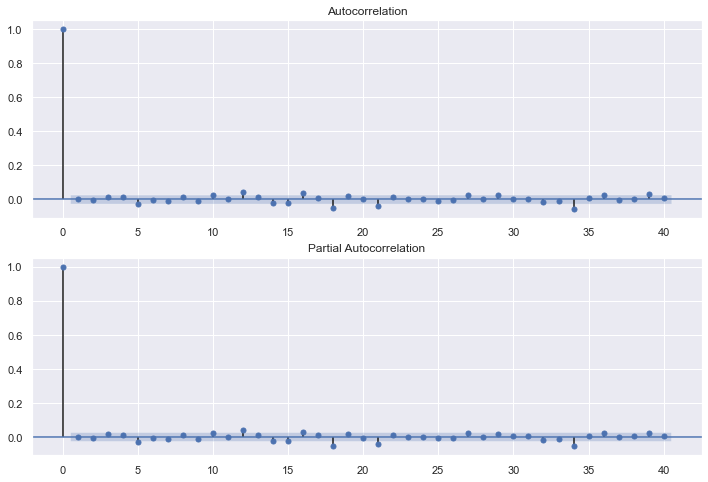

In [25]:
from scipy import stats
import statsmodels.api as sm
from scipy.stats import normaltest

residuals = spy_arima_fit.resid
print(normaltest(residuals))
if normaltest(residuals)[1] < .05:
    print('This distribution is not a normal distribution')
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(residuals ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(residuals)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)

### Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (1,1,1) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

In [26]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is [108.75755952  55.2641297   58.44904657  49.30112582  46.66773325
  44.5935113   43.40951923  42.58986726  42.44610287  43.72076468
  41.48386763  40.71818716  39.14465336  36.31850823  38.78642649
  38.69075262  38.50139294  36.80876818  38.15064553  38.60791882
  35.47009163  33.40437044  33.15998382  31.81114838  30.86704831
  31.05002451  32.92496508  32.88227445  32.73127971  30.27700245
  29.41100967  29.79442015  27.8442851   27.32326853  26.9510391
  27.5504231   26.52246565  26.1677226   26.28131405  26.36579226
  26.70084291  25.68474623  26.1691507   26.48312943  27.57863266
  29.23130318  29.75785946  27.14072387  26.21157116  25.11501519
  25.10836362  24.37753221  23.76982434  23.68817682  24.13020692
  22.58968001  25.22716337  25.7115119   24.52344018  25.20801357
  24.725052    23.7240947   22.03748889  21.82921205  21.64923142
  21.31992108  20.7715737   20.64728026  21.18410466  20.8738878
  20.85947188  20.24905545  20.2423572   20.2045

In [26]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[array([184.5022509]),
 array([238.13209089]),
 array([234.90574724]),
 array([244.28651455]),
 array([247.0566748])]

In [28]:
#save model
model_fit.save('arima_111.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')

In [27]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568,
 'ARIMA': 2.795754057940963}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

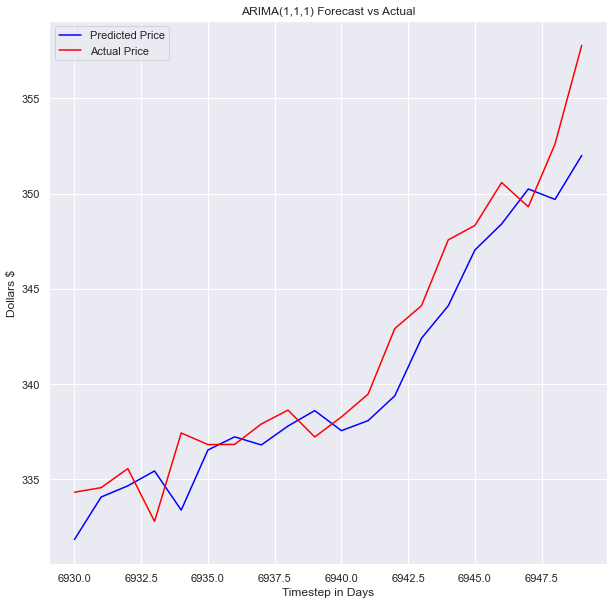

<Figure size 720x432 with 0 Axes>

In [38]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-20:], model_predictions[-20:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-20:], x_test[-20:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

#### Show Error in model vs actual

In [30]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

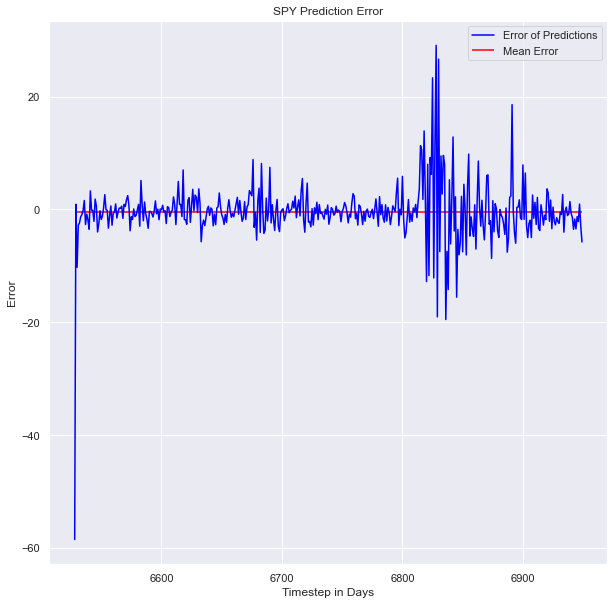

<Figure size 720x432 with 0 Axes>

In [36]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Summary of ALL Model Results

### Bringing in values from other deep learning models

In [39]:
model_mae_scores['linear_model'] = 3.8284044
model_mae_scores['dense_model'] = 5.4198823
model_mae_scores['rnn_seqtoseq'] = 6.204379
model_mae_scores['rnn_seqtovec'] = 23.704935
model_mae_scores['lstm_30day'] = 1.1875452
model_mae_scores['cnn_preprocessing_rnn_20'] = 15.492888
model_mae_scores['full_cnn'] = 3.5446732

In [40]:
# Store MAE scores
%store model_mae_scores

Stored 'model_mae_scores' (dict)


In [41]:
%store -r model_mae_scores
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071123,
 'SMA 5': 6.754151658767568,
 'ARIMA': 2.795754057940963,
 'linear_model': 3.8284044,
 'dense_model': 5.4198823,
 'rnn_seqtoseq': 6.204379,
 'lstm_30day': 1.1875452,
 'cnn_preprocessing_rnn_20': 15.492888,
 'full_cnn': 3.5446732}

In [42]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

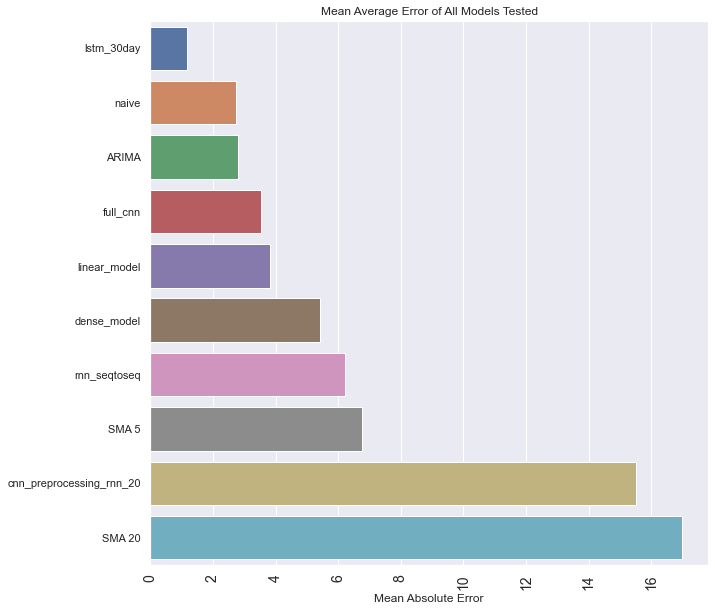

In [43]:
# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')
